# Работа с датасетом данных о доставке в электронной коммерции #

Ссылка на датасет: https://www.kaggle.com/prachi13/customer-analytics

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.linear_model import SGDClassifier

In [2]:
data = pd.read_csv("./datasets/ecommerce/Train.csv")

**Данные в датасете содержат следующие признаки:**

- ID: ID покупателя.
- Warehouse_block: Номер склада на котором храниться продукт (A,B,C,D,E...).
- Mode_of_shipment: Способ доставки (Ship, Flight and Road).
- Customer_care_calls: Число звонков сделанных покупателем по запросу на запрос отгрузки.
- Customer_rating: Рейтинг покупателя (от 1 - плохо, до 5 - отлично).
- Cost_of_the product: Стоймость в долларах США.
- Prior_purchases: Приоритет доставки.
- Product_importance: Суммарная оценка важности продукта по разным параметрам (low, medium, high).
- Gender: Пол покупателя.
- Discount_offered: Скидка на данный конкретный продукт.
- Weight_in_gms: Вес продукта в граммах.
- Reached_on_time: Целевой признак (1 - продукт НЕ БЫЛ доставлен вовремя, 0 - продукт был доставлен вовремя)

In [3]:
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [4]:
data.shape

(10999, 12)

## Подготовка данных ##

**Пропуски**<br>

In [5]:
data.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

Как видно на всем датасете пропуков нет.


**Преобразование признаков типа object к числовым типам**<br>
Посмотрим типы у признаков

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


Видим, что 4 признака имеют тип данных object, посмотрим их возможные уникальные значения (так как из описания датасета известно что их множества конечны)

In [7]:
du = {"Warehouse_block":[],"Mode_of_Shipment":[],"Product_importance":[],"Gender":[]}
for i in du.keys():
    du[i] = data[i].unique()
du

{'Warehouse_block': array(['D', 'F', 'A', 'B', 'C'], dtype=object),
 'Mode_of_Shipment': array(['Flight', 'Ship', 'Road'], dtype=object),
 'Product_importance': array(['low', 'medium', 'high'], dtype=object),
 'Gender': array(['F', 'M'], dtype=object)}

Проведем следующие замены в датасете:
- для признака Warehouse_block множество знаечний ['D','F','A','B','C'] заменим на [0,1,2,3,4] соотвественно;
- для Mode_of_Shipment - ['Flight','Ship','Road'], на [0,1,2]
- для Product_importance - ['low', 'medium', 'high'], на [0,1,2]
- для Gender - ['F', 'M'], на [0,1]

Создадим два словаря: кодировщик и декодировщик, соответственно.

In [8]:
du_encoder, du_decoder = du.copy(), du.copy()
for i in du:
    du_encoder[i] = { du[i][j]:j for j in range(0, len(du[i]))}
    du_decoder[i] = { j:du[i][j] for j in range(0, len(du[i]))}

du_encoder, du_decoder

({'Warehouse_block': {'D': 0, 'F': 1, 'A': 2, 'B': 3, 'C': 4},
  'Mode_of_Shipment': {'Flight': 0, 'Ship': 1, 'Road': 2},
  'Product_importance': {'low': 0, 'medium': 1, 'high': 2},
  'Gender': {'F': 0, 'M': 1}},
 {'Warehouse_block': {0: 'D', 1: 'F', 2: 'A', 3: 'B', 4: 'C'},
  'Mode_of_Shipment': {0: 'Flight', 1: 'Ship', 2: 'Road'},
  'Product_importance': {0: 'low', 1: 'medium', 2: 'high'},
  'Gender': {0: 'F', 1: 'M'}})

Осуществим непосредственно замену

In [9]:
for i in du_encoder:
    data[i] = data[i].map(du_encoder[i])
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,0,0,4,2,177,3,0,0,44,1233,1
1,2,1,0,4,5,216,2,0,1,59,3088,1
2,3,2,0,2,2,183,4,0,1,48,3374,1
3,4,3,0,3,3,176,4,1,1,10,1177,1
4,5,4,0,2,2,184,3,1,0,46,2484,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   ID                   10999 non-null  int64
 1   Warehouse_block      10999 non-null  int64
 2   Mode_of_Shipment     10999 non-null  int64
 3   Customer_care_calls  10999 non-null  int64
 4   Customer_rating      10999 non-null  int64
 5   Cost_of_the_Product  10999 non-null  int64
 6   Prior_purchases      10999 non-null  int64
 7   Product_importance   10999 non-null  int64
 8   Gender               10999 non-null  int64
 9   Discount_offered     10999 non-null  int64
 10  Weight_in_gms        10999 non-null  int64
 11  Reached.on.Time_Y.N  10999 non-null  int64
dtypes: int64(12)
memory usage: 1.0 MB


Из полученного можем видеть, что все категориальные признаки из строчных заменились на числовые 

## Визуализация данных ##

**Отобразим корреляцию признаков с помощью тепловой карты**

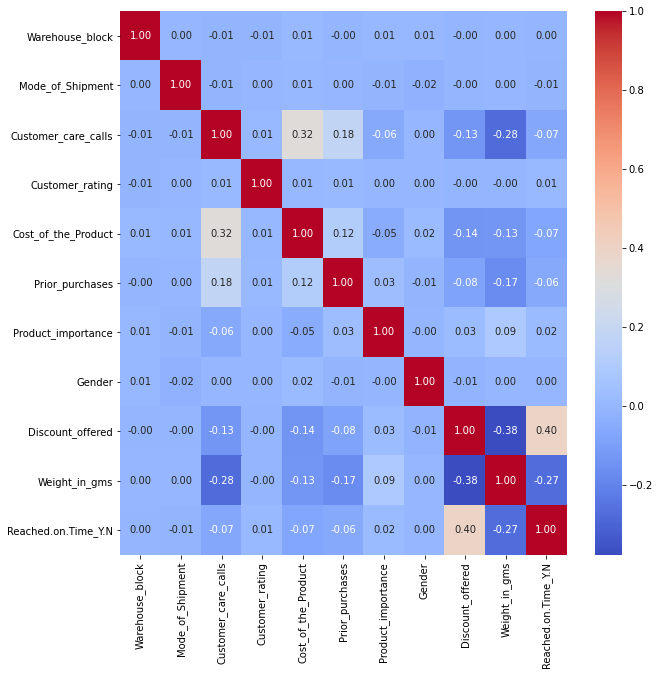

In [11]:
fig, ax = plt.subplots(figsize=(10,10)) 

features = list(data.columns).copy()
features.remove("ID")
features

sns.heatmap(data[features].corr(), annot=True, fmt=".2f", cmap= 'coolwarm');

Из тепловой карты можно увидеть что целевой признак не имеет какой либо выраженной корреляций с остальными признаками, кроме признаков "Discount_offered" (коэффициент корреляции составляет 0.4) и "Weight_in_gms" (-0.27).
<br> Из чего можно сделать промежуточный вывод, что если вес товара увеличивается, то вероятность его несвоевременной доставки уменьшается, что логично, ведь маленькие товары возможно теряются или отправляются партиями, из-за чего происходят задержки, а также при возрастании предложенной скидки вероятность несвоевременной доставки увеличивается, что также логично, так как компании продавшая товар со скидкой имеет меньше мотивации работать лучше в данном конкретном случае.<br> 
Также по данной карте можно сказать, что в датасете нет признаков напрямую или очень сильно зависящих друг от друга, из-за чего они могли бы быть полностью бесполезными.

**Диаграммы рассеивания признаков и графики функции распредления признаков**<br>
Построим данные диаграммы по заинтересовавшим нас выше признакам "Discount_offered" и "Weight_in_gms" в зависимости от целевого признака

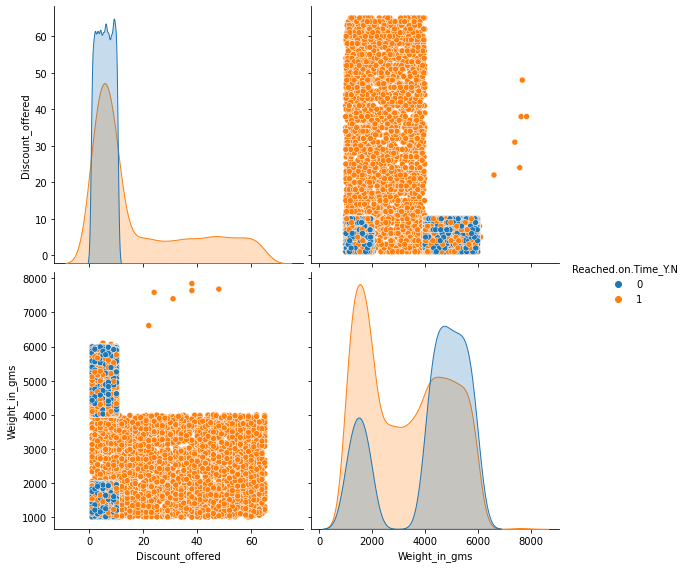

In [12]:
sns.pairplot(data[["Discount_offered", "Weight_in_gms","Reached.on.Time_Y.N"]], 
             hue="Reached.on.Time_Y.N", height=4);

Из данных результатов можно сделать уже обоснованные выводы:
- При скидке от 10 несвоевременная доставка почти на 100% гарантирована
- При весе товара от 2000 до 4000 грамм и от 6000 грамм несвоевременная доставка также практически на 100% гарантирована
- Распределение признака "Discount_offered" для своевременной доставки имеет равномерное распределение в дапазоне [2000;4000] грамм, для несвоевременной напоминает гамма-распределение
- Распределение признака "Weight_in_gms" дважды распределяется нормально если поделить функцию распределения на два диапазона [0;3000], (3000;8000)

## Нормализация данных и разделение датасета на обучающую и тестовую выборку ##

**Нормализация данных**
<br>Количество сообщений по целевому признаку до выравнивания соотношения

In [13]:
value_count = data["Reached.on.Time_Y.N"].value_counts()
value_count

1    6563
0    4436
Name: Reached.on.Time_Y.N, dtype: int64

Количество сообщений по целевому признаку после выравнивания соотношения

In [14]:
data = data.sort_values(by = "Reached.on.Time_Y.N").iloc[: value_count[0]*2 ]
value_count = data["Reached.on.Time_Y.N"].value_counts()
value_count

0    4436
1    4436
Name: Reached.on.Time_Y.N, dtype: int64

**Разделим данные на обучающую и тестовую выборку**

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(["Reached.on.Time_Y.N"], axis=1), data["Reached.on.Time_Y.N"], random_state = 100, test_size = 0.1)
y_train.value_counts(), y_test.value_counts()

(1    4015
 0    3969
 Name: Reached.on.Time_Y.N, dtype: int64,
 0    467
 1    421
 Name: Reached.on.Time_Y.N, dtype: int64)

## Линейный классификатор ##

Подберем подходящую модель на обучающей выборке

In [16]:
logit = LogisticRegression()
logit.fit(x_train, y_train);

Точность предсказания

In [17]:
round(logit.score(x_test, y_test), 3)

0.702

## Метод ближайших соседей ##

Узнаем значение K (число соседей) при котором модель делает предсказания с наибольшей точностью и непосредственно точность при этом значении

In [18]:
K = { k : round(KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train).score(x_test, y_test), 3)  for k in range(2, 25)}
[k for k in K.keys() if K[k] == max(K.values())][0], max(K.values())

(4, 0.78)

Также выведем график изменения точности в зависимости от изменения числа соседей

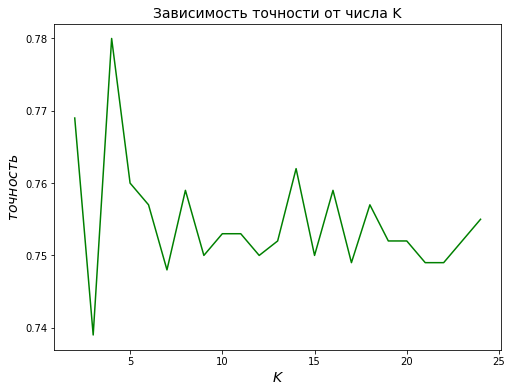

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(K.keys(), K.values(), 'green')
plt.title(r'Зависимость точности от числа K', size=14)
plt.xlabel(r'$K$', size=14)
plt.ylabel(r'$точность$', size = 14)
plt.show()

## Метод опорных элементов ##

Подберем подходящую модель на обучающей выборке

In [20]:
clf = svm.SVC()
clf.fit(x_train, y_train);

Точность предсказания

In [21]:
round(clf.score(x_test, y_test), 3)

0.758

## Метод стохастического градиентного спуска (доп.) ##

Подберем подходящую модель на обучающей выборке

In [22]:
clf = SGDClassifier()
clf.fit(x_train, y_train);

Точность предсказания

In [23]:
round(clf.score(x_test, y_test), 3)

0.645